<a href="https://colab.research.google.com/github/tylerscott3/CS290/blob/main/GaussianandClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:

from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [81]:

iris = load_iris()
df = pd.DataFrame( iris.data, columns = iris.feature_names)


In [82]:

data = load_iris()
X = data.data
y = data.target

In [83]:

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [85]:

target_names = {
    0:'setosa',
    1:'versicolor',
    2:'virginica'
}

df['species_name'] = df['species'].map(target_names)
df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


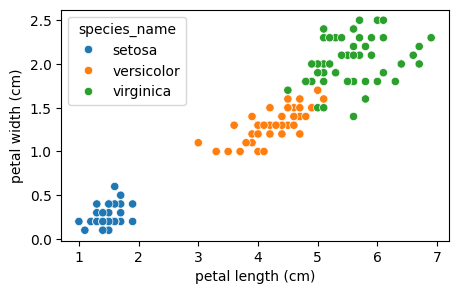

In [86]:


plt.figure(figsize=(5, 3))
sns.scatterplot( x = "petal length (cm)", y = "petal width (cm)", data = df, hue = "species_name");


In [87]:

centroids = df.groupby("species_name")[["petal length (cm)", "petal width (cm)"]].mean()

In [88]:

centroids


,petal length (cm),petal width (cm)
species_name,,
setosa,1.462,0.246
versicolor,4.260,1.326
virginica,5.552,2.026


In [89]:

centroids.loc["versicolor"]

,versicolor
petal length (cm),4.260
petal width (cm),1.326


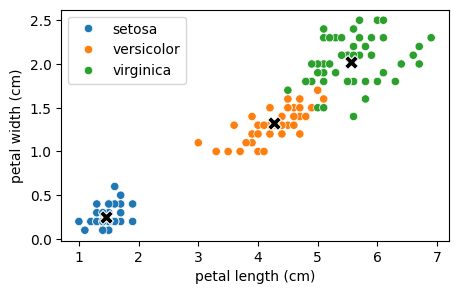

In [90]:

plt.figure(figsize=(5, 3))
sns.scatterplot( x = "petal length (cm)", y = "petal width (cm)", data = df, hue = "species_name")
sns.scatterplot( x = "petal length (cm)", y = "petal width (cm)", data = centroids, c = "black", marker="X", s = 100);

In [91]:
df = df.drop(columns=["species", "species_name"])

In [92]:


df[['current_cluster']] = -1
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,-1
1,4.9,3.0,1.4,0.2,-1
2,4.7,3.2,1.3,0.2,-1
3,4.6,3.1,1.5,0.2,-1
4,5.0,3.6,1.4,0.2,-1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,-1
146,6.3,2.5,5.0,1.9,-1
147,6.5,3.0,5.2,2.0,-1
148,6.2,3.4,5.4,2.3,-1


In [93]:

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

In [94]:

def get_specified_centroids(df, k, specified_centroids=None):
    if specified_centroids is not None:

        return pd.DataFrame(specified_centroids, columns=df.columns[:-1])
    else:
        return get_random_centroids(df, k)


In [95]:

num_centroids = int(input("How many centroids?: "))
def get_random_centroids(df, k):
    return df.sample(k)[df.columns[:-1]]

get_random_centroids(df, num_centroids)


How many centroids?: 3


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
124,6.7,3.3,5.7,2.1
7,5.0,3.4,1.5,0.2
110,6.5,3.2,5.1,2.0


In [96]:

def new_centroids(old_centroids, new_centroids):
    if old_centroids.empty:
        return False
    return np.allclose(old_centroids.values, new_centroids.values, atol=1e-3)

In [97]:
def update_centroids(df):

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()  # Get numeric columns
    numeric_cols.remove('current_cluster')  # Exclude the cluster assignment column
    return df.groupby("current_cluster")[numeric_cols].mean() # Only average selected cols


In [98]:

def plot_clusters_2d(df, centroids, iteration, x_feature="petal length (cm)", y_feature="petal width (cm)"):
    plt.figure(figsize=(5, 3))
    sns.scatterplot(x=x_feature, y=y_feature, data=df, hue="current_cluster", palette="Set1", marker="o", legend=None)
    plt.scatter(
        centroids[x_feature], centroids[y_feature],
        color="black", marker="X", s=200, label="Centroids"
    )
    plt.title(f'Iteration {iteration}')
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.legend()
    plt.show()

In [99]:
def get_cluster(df, centroids, plot=True):
    # initializes old centroids
    old_centroids = pd.DataFrame()
    iteration = 0
    while not new_centroids(old_centroids, centroids):
        # updates old centroids
        old_centroids = centroids.copy()
        # iterate over each point in the data frame
        for i in df.index:
            # store distances from current point to each centroid
            distances = []
            # iterate over each centroid
            for _, centroid in centroids.iterrows():
                # calculate euclidean distance from current point to current centroid
                distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], centroid))
            # assign the point to the cluster with the closest centroid
            closest_cluster = np.argmin(distances)
            df.loc[i, 'current_cluster'] = closest_cluster

        if plot:
          # plot clusters and centroids
          get_cluster(df, centroids, iteration)
        #update centroids
        centroids = update_centroids(df)
        iteration += 1
    return df

In [100]:

get_random_centroids(df, num_centroids)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
15,5.7,4.4,1.5,0.4
79,5.7,2.6,3.5,1.0
31,5.4,3.4,1.5,0.4


In [101]:

centroids = get_random_centroids(df, num_centroids)

In [102]:

def calculate_accuracy(df, clustered_df, target='species'):
    accuracy = 0
    for i in df.index:
        if df.loc[i, target] == clustered_df.loc[i, 'current_cluster']:
            accuracy += 1
    return accuracy / len(df)

In [103]:
def get_inertia(df, centroids):
    # initialize as 0
    inertia = 0
    # loop through each point
    for i in df.index:
        # get cluster assignment
        cluster = df.loc[i, 'current_cluster']
        # calculate euclidean distance between the point and its assigned centroid
        distance = euclidean_distance(df.loc[i, df.columns[:-1]], centroids.loc[cluster])
        # add the squared distance to the total inertia
        inertia += distance**2
    return inertia

In [104]:
clustered_df = get_cluster(df, get_random_centroids(df, num_centroids))

In [105]:

inertia = get_inertia(clustered_df, update_centroids(clustered_df))
inertia

78.85566582597727

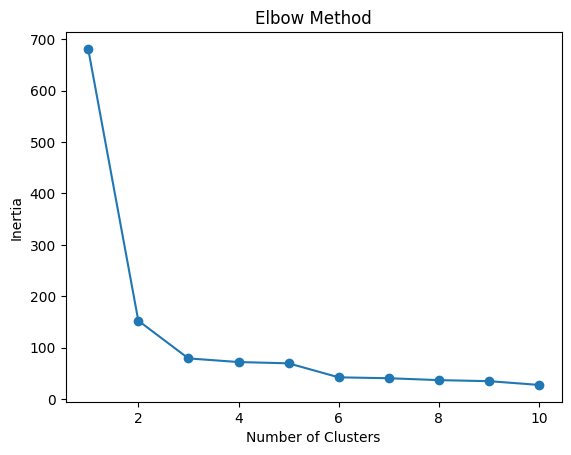

In [106]:

inertias = []
for i in range(1, 11):
    centroids = get_random_centroids(df, i)
    clustered_df = get_cluster(df, centroids, plot=False)
    inertia = get_inertia(clustered_df, update_centroids(clustered_df))
    inertias.append(inertia)


plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [107]:

def initialize_centroids(df, k):
    # initialize list to hold k centroids
    centroids = []
    # randomly select first centroid
    first_centroid = df.sample(1).iloc[0]
    # add it to the centroid list
    centroids.append(first_centroid)
    # get remaining k-1 centroids
    for i in range(1, k):
        # initialize list to hold distances from new centroids to the first centroid
        distances = []
        # loop through each point in the data frame
        for i in df.index:
            point = df.loc[i, df.columns[:-1]]
            # Calculate the distance from the current point to each centroid
            min_distance = min(euclidean_distance(point, centroid) for centroid in centroids)
            distances.append(min_distance**2)  # Append squared distance
        # compute probabilities
        probabilities = distances / np.sum(distances)
        new_centroid = df.sample(1, weights=probabilities).iloc[0]
        # add new centroid to list
        centroids.append(new_centroid)

    return pd.DataFrame(centroids, columns=df.columns[:-1])



In [108]:

get_cluster(df, initialize_centroids(df, num_centroids))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),current_cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,0
148,6.2,3.4,5.4,2.3,0


In [109]:

def mean_cluster_distance(df, point_index):
    distances = []
    # get the current cluster of the point
    current_cluster = df.loc[point_index, 'current_cluster']
    # get all points in the current cluster
    cluster_points = df[df['current_cluster'] == current_cluster]
    # loop through all points in current cluster
    for i in cluster_points.index:
        if i != point_index:
            # calculate and append mean distance between the current point and all other points
            distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], df.loc[point_index, df.columns[:-1]]))

    return np.mean(distances) if distances else 0

In [110]:

def mean_closest_cluster_distance(df, point_index):
    total_distances = []
    # get the current cluster
    current_cluster = df.loc[point_index, 'current_cluster']
    # get all other clusters
    other_clusters = df[df['current_cluster'] != current_cluster]
    # loop through each unique cluster in other_clusters
    for cluster in other_clusters['current_cluster'].unique():
        # get all points belonging to the cluster being considered
        cluster_points = df[df['current_cluster'] == cluster]
        # compute distance to all points in the current cluster
        distances = []
        for i in cluster_points.index:
            # calculate distance between this point and each point in the current cluster
            distances.append(euclidean_distance(df.loc[i, df.columns[:-1]], df.loc[point_index, df.columns[:-1]]))
        total_distances.append(np.mean(distances))
    return min(total_distances)

In [111]:

def get_silhouette_coefficients(df):
    silhouette_scores = []
    for i in df.index:
        # Calculate silhouette for each point
        a = mean_cluster_distance(df, i)
        b = mean_closest_cluster_distance(df, i)
        silhouette_scores.append((b - a) / max(a, b))
    return silhouette_scores



In [112]:

def assign_silhouette_to_clusters(df, silhouette_scores):
    df['silhouette_score'] = silhouette_scores
    return df



In [113]:

sil_score = get_silhouette_coefficients(df)

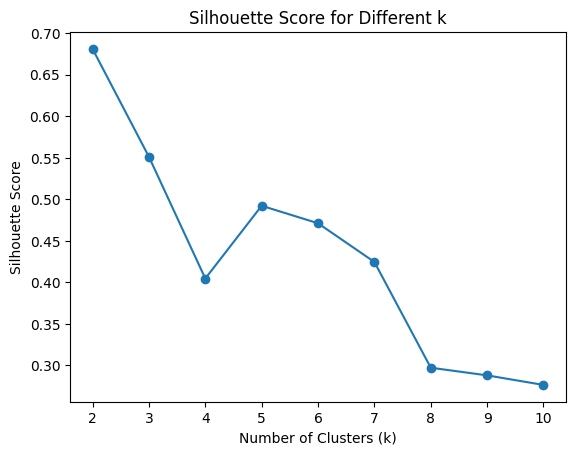

In [114]:
# Initialize lists to store silhouette scores for different k values
sil_scores = []
for k in range(2, 11):  # Example testing from k=2 to k=10
    centroids = get_specified_centroids(df, k)  # Use the specified or random centroids
    clustered_df = get_cluster(df, centroids, plot=False)  # Get the clustered data

    # Calculate silhouette coefficients for the entire dataset
    silhouette_scores = get_silhouette_coefficients(clustered_df)  # Compute silhouette scores for all points
    sil_scores.append(np.mean(silhouette_scores))  # Append mean score for this k

plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Score for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [116]:

df["species"] = iris.target

In [117]:
from collections import Counter
import numpy as np

def calculate_accuracy(df, target='species'):

    predicted_labels = []


    for cluster in np.unique(df['current_cluster']):

        cluster_labels = df[df['current_cluster'] == cluster][target].tolist()

        most_common_label = Counter(cluster_labels).most_common(1)[0][0]

        predicted_labels.extend([most_common_label] * len(cluster_labels))

    correct_predictions = sum(df[target] == predicted_labels)
    accuracy = correct_predictions / len(df)

    return accuracy

accuracy = calculate_accuracy(df)
print(f"Accuracy of the K-Means clustering: {accuracy:.4f}")


Accuracy of the K-Means clustering: 0.4867


GAUSSIAN


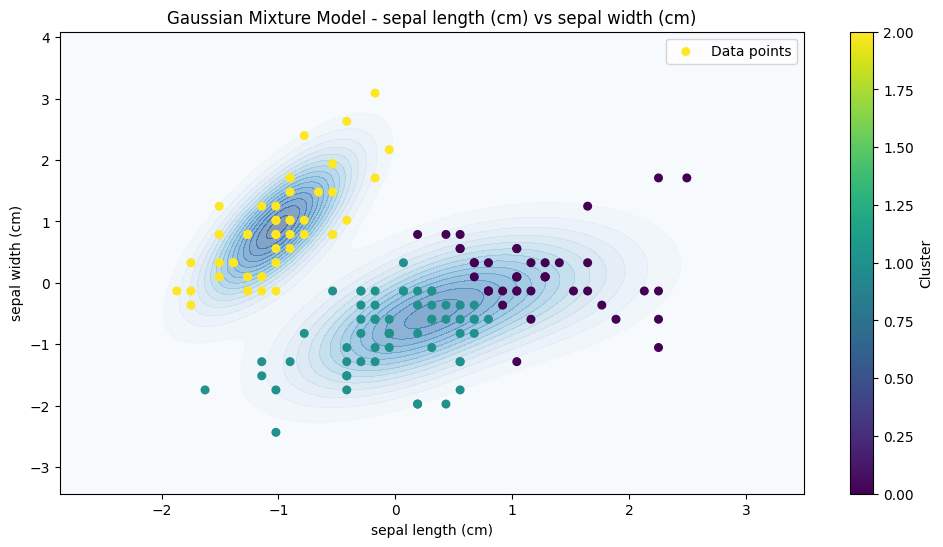

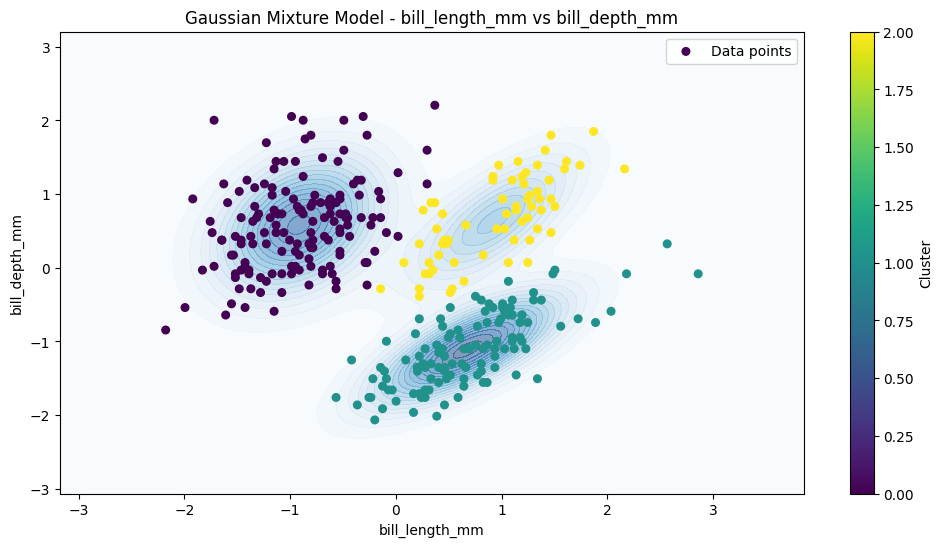

Accuracy of GMM on Iris: 0.79
Accuracy of GMM on Penguins: 0.96


In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

def plot_gaussian_mixture(gm, X, feature1, feature2):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

    log_prob = gm.score_samples(grid_points)
    pdf = np.exp(log_prob).reshape(xx.shape)

    plt.contourf(xx, yy, pdf, levels=20, cmap='Blues', alpha=0.5)

    plt.scatter(X[:, 0], X[:, 1], c=gm.predict(X), cmap='viridis', s=30, label="Data points")
    plt.title(f'Gaussian Mixture Model - {feature1} vs {feature2}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)


iris = load_iris()
X_iris = iris.data[:, :2]
y_iris = iris.target

scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

gmm_iris = GaussianMixture(n_components=3, random_state=42)
gmm_iris.fit(X_iris_scaled)

plt.figure(figsize=(12, 6))
plot_gaussian_mixture(gmm_iris, X_iris_scaled, 'sepal length (cm)', 'sepal width (cm)')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()


penguins = sns.load_dataset('penguins').dropna()
X_penguins = penguins[['bill_length_mm', 'bill_depth_mm']].values
y_penguins = penguins['species'].astype('category').cat.codes

X_penguins_scaled = scaler.fit_transform(X_penguins)

gmm_penguins = GaussianMixture(n_components=3, random_state=42)
gmm_penguins.fit(X_penguins_scaled)

plt.figure(figsize=(12, 6))
plot_gaussian_mixture(gmm_penguins, X_penguins_scaled, 'bill_length_mm', 'bill_depth_mm')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

def calculate_accuracy(true_labels, predicted_labels):
    from scipy.stats import mode
    labels = np.zeros_like(predicted_labels)
    for i in range(3):  # 3 clusters
        mask = (predicted_labels == i)
        labels[mask] = mode(true_labels[mask])[0]
    return accuracy_score(true_labels, labels)

iris_gmm_predictions = gmm_iris.predict(X_iris_scaled)
iris_gmm_accuracy = calculate_accuracy(y_iris, iris_gmm_predictions)
print(f"Accuracy of GMM on Iris: {iris_gmm_accuracy:.2f}")

penguins_gmm_predictions = gmm_penguins.predict(X_penguins_scaled)
penguins_gmm_accuracy = calculate_accuracy(y_penguins, penguins_gmm_predictions)
print(f"Accuracy of GMM on Penguins: {penguins_gmm_accuracy:.2f}")


